In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from bayesian_statistics.utils import *


## データの生成

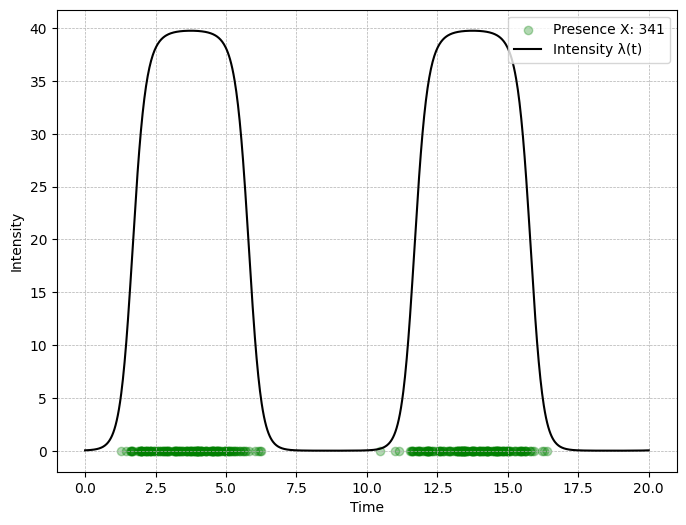

In [2]:
# パラメータの設定
beta_true = np.array([-2, 0, 0, 5, -5])  # 真のパラメータ
lambda_star_true = 40  # 真の λ*

# 複雑な設計行列の関数
def create_complex_design_matrix(t, omega=np.pi / 5):
    return np.vstack([
        np.ones_like(t),
        t,
        t**2,
        np.sin(omega * t),
        np.cos(omega * t)
    ]).T

# 真の強度関数の設定
true_intensity_func = IntensityFunction(
    design_matrix_func=create_complex_design_matrix,
    beta=beta_true,
    lambda_star=lambda_star_true
)

# --- 2. データの生成 ---

T = 20.0  # 時間範囲を広げる
W_obs, y_obs, t_obs = generate_IPP(T, true_intensity_func, generate_U_flag=False)

# イベントのプロット
t1 = t_obs[y_obs == 1]
t0 = t_obs[y_obs == 0]
plot_events(t0, t1, T, true_intensity_func)


In [5]:
# 事前分布の設定
prior_beta_mean = np.zeros(len(beta_true))
prior_beta_cov = np.eye(len(beta_true)) * 10
prior_lambda_shape = 2.0
prior_lambda_rate = 1.0

# MCMC の実行
num_iterations = 20000
intensity_func = true_intensity_func.copy()

beta_samples, lambda_star_samples = mcmc_sampler(
    T=T,
    intensity_func=intensity_func,
    W_obs=W_obs,
    y_obs=y_obs,
    num_iterations=num_iterations,
    prior_beta_mean=prior_beta_mean,
    prior_beta_cov=prior_beta_cov,
    prior_lambda_shape=prior_lambda_shape,
    prior_lambda_rate=prior_lambda_rate
)

burn_in = 500  
beta_samples = np.array(beta_samples)[burn_in:, :]
lambda_star_samples = np.array(lambda_star_samples)[burn_in:]

100%|██████████| 20000/20000 [00:48<00:00, 409.26it/s]


/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill

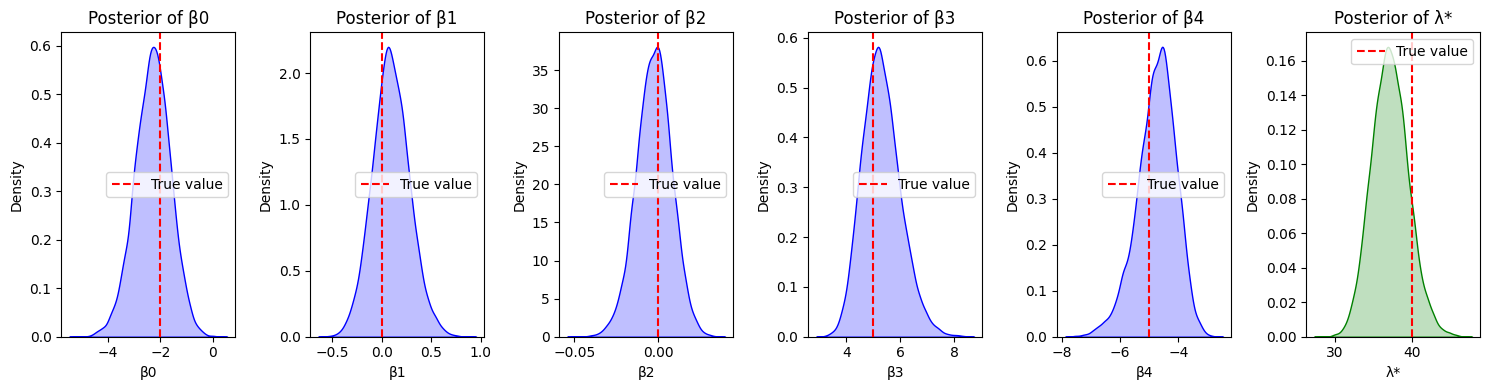

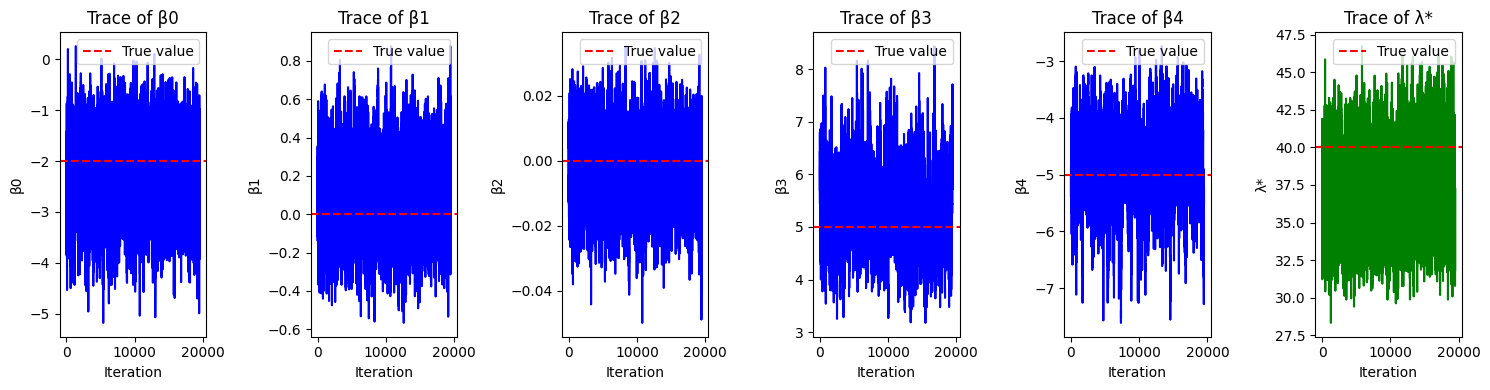

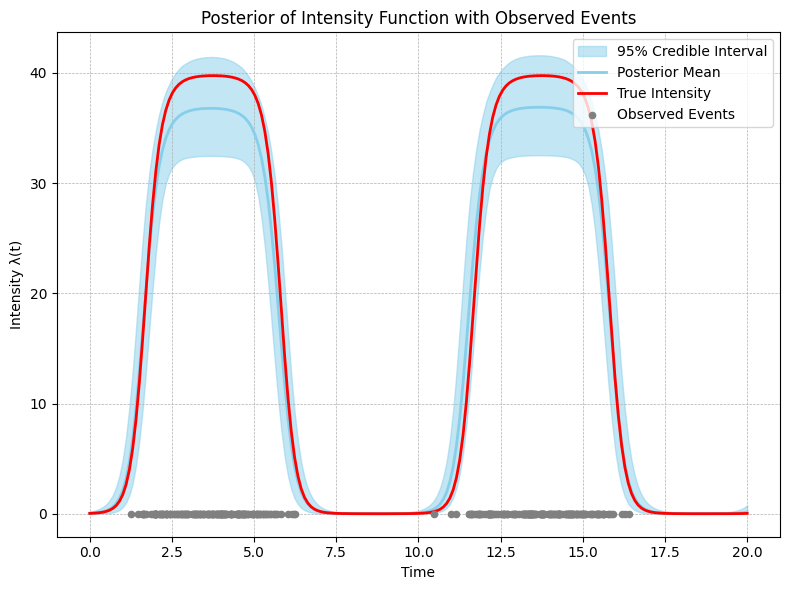

In [6]:
plot_posterior_distributions(
    beta_samples=np.array(beta_samples), 
    lambda_star_samples=np.array(lambda_star_samples),
    true_beta=beta_true,  # 真の値が既知の場合
    true_lambda_star=lambda_star_true  # 真の値が既知の場合
)

plot_trace_plots(
    beta_samples=beta_samples, 
    lambda_star_samples=lambda_star_samples,
    true_beta=beta_true,
    true_lambda_star=lambda_star_true
)

plot_intensity_posterior_with_events(
    beta_samples=np.array(beta_samples),
    lambda_star_samples=np.array(lambda_star_samples),
    intensity_func=intensity_func,
    T=T,
    events=t_obs[y_obs == 1] ,
    num_points=200,
    credible_interval=0.95,
    true_intensity_func=lambda t:true_intensity_func.lambda_func(t)  # 真の強度関数
)
